In [1]:
import numpy as np
import pandas as pd
import os
import glob
from sklearn.metrics import pairwise
from IPython.display import HTML
import extract_feature_vector
from IPython.display import Image as iImage
import base64
from PIL import Image
from io import BytesIO
import topfivebreeds
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
pd.set_option('display.max_colwidth', -1)

def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((300, 1000), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

In [3]:
def maketop10df(top10list):
    simpetsdf = pd.DataFrame(columns=['file','name','breeds','location','contact_email','shelterId','cossim'])
    for simpic in top10list:    
        petid = simpic.split('_')[0]
        simpetsdf.loc[simpic,'file'] = PETPHOTOPATH+simpic+'.jpg'
        simpetsdf.loc[simpic,'name'] = pfdf.loc[petid,'name']
        simpetsdf.loc[simpic,'breeds'] = pfdf.loc[petid,'breeds']
        simpetsdf.loc[simpic,'location'] = pfdf.loc[petid,'contact']['city']['$t']+', '+pfdf.loc[petid,'contact']['state']['$t']
        if pfdf.loc[petid,'contact']['email']:
            simpetsdf.loc[simpic,'contact_email'] = pfdf.loc[petid,'contact']['email']['$t']
        simpetsdf.loc[simpic,'shelterId'] = pfdf.loc[petid,'shelterId']
        simpetsdf.loc[simpic,'cossim'] = similarity.loc[simpic]
    return simpetsdf

In [4]:
featuredf = pd.read_pickle("pf_feature_vecs.pkl")
pfdf = pd.read_pickle("petsdf.pkl")

In [5]:
PETPHOTOPATH='/Users/miaCDIPS/petphotos/'
TESTINPUTPATH = "/Users/miaCDIPS/Desktop/testpics/"

In [6]:
feature_columns = featuredf.columns

In [7]:
for ind in featuredf.index:
    petid = ind.split('_')[0]
    featuredf.loc[ind,'breed'] = pfdf.loc[petid,'breeds'][0]

# LET'S INPUT AN IMAGE HERE
Here, we have already trained our neural network, and input an image to obtain the model's prediction (which breed of dog), but more importantly, to extract the feature vector used to describe the image.

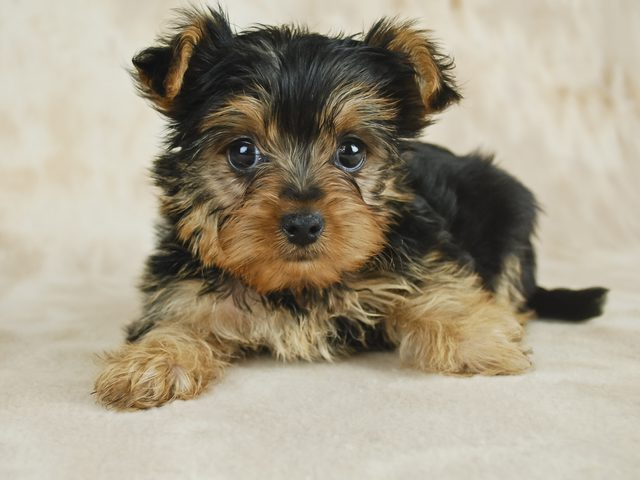

In [8]:
input_image_filepath = TESTINPUTPATH + "yorkie.jpg"
inputimg = iImage(filename = input_image_filepath, height = 600)
display(inputimg)

## Our re-trained neural network can predict which breed:

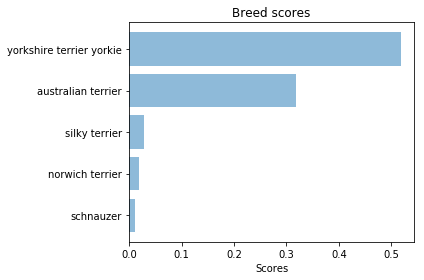

In [9]:
topfivebreeds.top5graph(input_image_filepath)

## but even several categorical labels fail to capture the complexity of a dog's appearance.  Instead let's describe our dog with a 2048-dimensional feature _vector_...

## ...and compare against the other dogs in our image database.  
We measure the cosine similarity between our input and every other dog in our database, getting a similarity score for each.  Let's take a look at the 10 most similar.

In [10]:
input_vector = extract_feature_vector.run_inference_on_image(input_image_filepath)
similarity = pd.Series(np.squeeze(pairwise.cosine_similarity(featuredf[feature_columns],input_vector.reshape(1,-1))), index=featuredf.index)


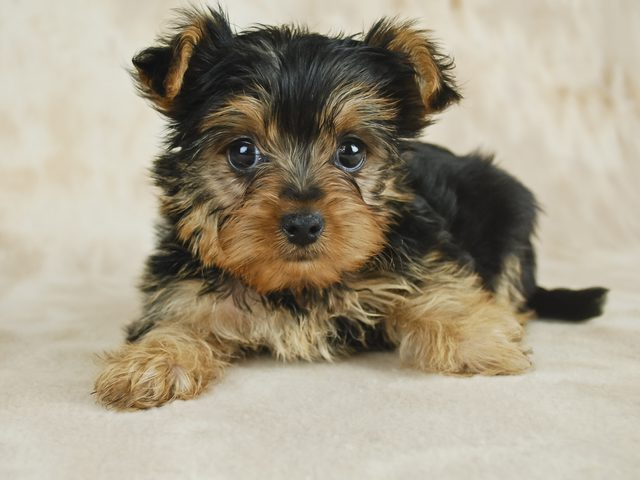

file,name,breeds,location,contact_email,shelterId,cossim
,Sprocket,"[Schnauzer, Yorkshire Terrier Yorkie]","Richardson, TX",adopt@tmhpr.com,TX1421,0.810314
,Angus,"[Yorkshire Terrier Yorkie, Schnauzer]","Baton Rouge, LA",bryorkiemom@yahoo.com,LA223,0.80138
,BUDDY,"[Yorkshire Terrier Yorkie, ]","New York, NY",petsofstfrancis@aol.com,NY587,0.796046
,Kobe # 1274,"[Yorkshire Terrier Yorkie, ]","Nixa, MO",route66rescue@yahoo.com,MO562,0.782645
,Sika,"[Yorkshire Terrier Yorkie, ]","Auburn, NE",hua@hua.org,NE83,0.781605
,Skylar is still a puppy!,"[Brussels Griffon, Border Terrier]","Redondo Beach, CA",contactus@dexterfoundation.com,CA1456,0.780765
,Kobe # 1274,"[Yorkshire Terrier Yorkie, ]","Nixa, MO",route66rescue@yahoo.com,MO562,0.780128
,Sprocket,"[Schnauzer, Yorkshire Terrier Yorkie]","Richardson, TX",adopt@tmhpr.com,TX1421,0.779231
,Taz AD in TX,"[Chihuahua, Yorkshire Terrier Yorkie]","Providence, RI",friendsoha@yahoo.com,RI76,0.773993
,Momma Bear,"[Yorkshire Terrier Yorkie, ]","Palm City, FL",floridayorkierescue@yahoo.com,FL858,0.772776

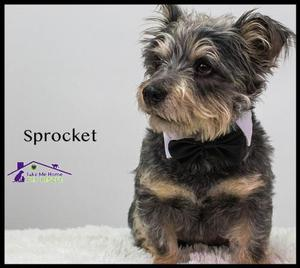
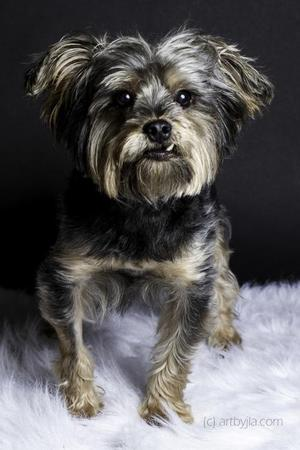
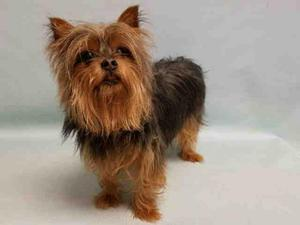
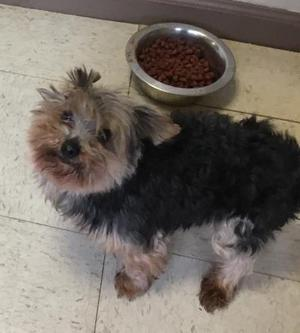
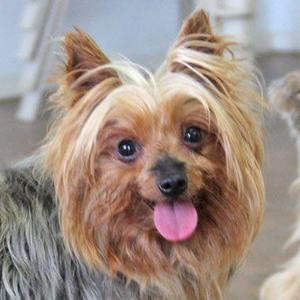
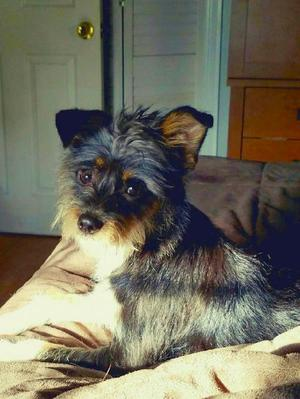
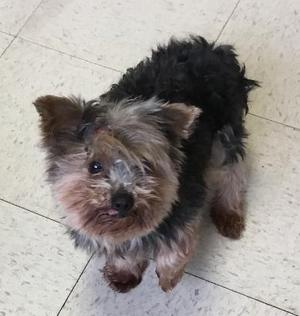
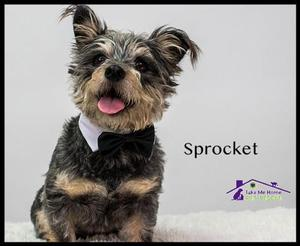
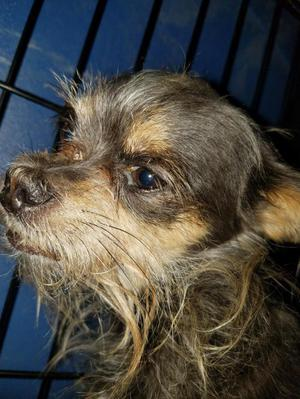
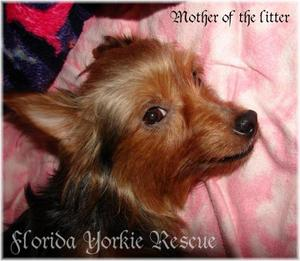

In [11]:
top10list = similarity.sort_values(ascending=False).head(10).index
simpetsdf = maketop10df(top10list)
display(inputimg)
HTML(simpetsdf.to_html(formatters={'file': image_formatter}, escape=False,index=False))

In [ ]:
import time

from sklearn.manifold import TSNE
rndperm = np.random.permutation(featuredf.index)

n_sne = 10000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(featuredf.loc[rndperm[:n_sne],feature_columns].values)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


In [ ]:
df_tsne = featuredf.loc[rndperm[:n_sne],:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]
popbreeds = df_tsne.groupby('breed').count().sort_values('x-tsne',ascending=False).head().index
df_tsne_filtered = df_tsne.loc[df_tsne['breed'].isin(list(popbreeds)+['Mixed Breed'])]

In [ ]:
g=sns.lmplot('x-tsne', 'y-tsne', data=df_tsne_filtered, hue='breed', fit_reg=False,scatter_kws={"s": 10})
g.fig.set_size_inches(13,7)
plt.show()